In [270]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


In [428]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query1 = """
    SELECT
        g.result,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result != 0
        AND p.eval is not NULL
    """

query2 = """
    SELECT 
        g.result,
        g.elo_white - g.elo_black as elo_dif
    FROM games g
    WHERE g.result != 0
    """

query3 = """
    SELECT 
        p.eval,
        COUNT(g.url)
    FROM positions p JOIN games g
    ON g.rowid = p.game_id
    GROUP BY g.url
    """

with sqlite3.connect("games2.sqlite") as con:
    con.row_factory = dict_factory
    res = con.execute(query1)
    data = pd.DataFrame(res)

con.close()


In [444]:
g = data.groupby("url").count()
data2 = data.merge(g.result, on="url", suffixes=("", "_y"))
data2.weight = data2.weight / data2.result_y


<AxesSubplot: xlabel='ply', ylabel='eval'>

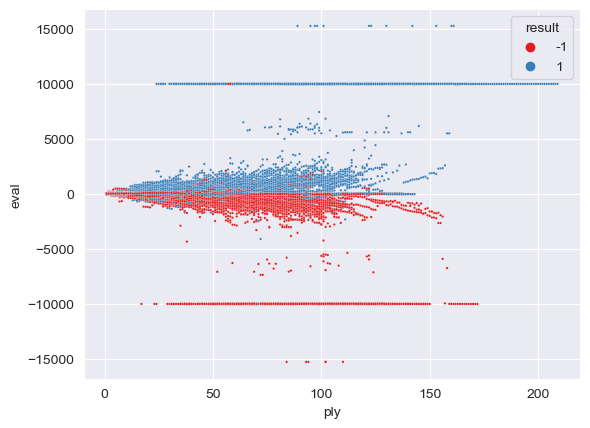

In [445]:
sns.scatterplot(
    data2,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)


In [446]:
sns.regplot(
    data=(data + 1) / 2,
    x="eval",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


TypeError: can only concatenate str (not "int") to str

In [520]:
random_state = 42

features = [
    "eval",
    # "ply",
    # "elo_dif",
]
# features = ["eval_min"]

X = data2[features]
y = data2.result
weights = data2.weight * 1000

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=random_state, stratify=y
)

scaler = StandardScaler()

classifier = LogisticRegressionCV(
    max_iter=1000,
    Cs=50,
    scoring="f1",
    # Cs=[1/10000],
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=10),
    # fit_intercept=False,
    class_weight="balanced",
)

model = Pipeline(
    steps=[
        ("scaler", scaler),
        ("classifier", classifier),
    ]
)

model.fit(X_train, y_train, classifier__sample_weight=weights_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegressionCV(Cs=50, class_weight='balanced',
                                      l1_ratios=array([0.0, 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667, 0.77778,
       0.88889, 1.0]),
                                      max_iter=1000, n_jobs=-1,
                                      penalty='elasticnet', random_state=42,
                                      scoring='f1', solver='saga'))])

In [521]:
print(f"Accuracy: \n {model.score(X_test, y_test, sample_weight=weights_test)}")
scale = model.named_steps["scaler"].scale_
mean = model.named_steps["scaler"].mean_

coefs = model.named_steps["classifier"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["classifier"].intercept_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["classifier"].C_
print(f"Regularization strenght: \n {cs}")

l1_ratio = model.named_steps["classifier"].l1_ratio_
print(f"L1 Ratio: {l1_ratio}")


Accuracy: 
 0.6960035639833435
Coefficients: 
 [[0.0005596]]
Intercept: 
 [0.064301]
Regularization strenght: 
 [0.0001]
L1 Ratio: [0.0]


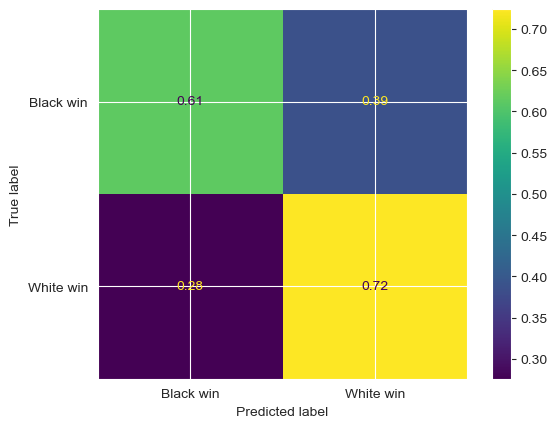

In [522]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    sample_weight=weights_test,
    normalize="true",
    display_labels=[
        "Black win",
        # "Draw",
        "White win",
    ],
)


In [512]:
def p(X, exponent, intercept):
    p = 1 / (1 + np.exp(-X * exponent - intercept))
    return p


In [513]:
data2.groupby("result").count()

,url,eval,ply,elo_dif,weight,result_y
result,,,,,,
-1,24227,24227,24227,24227,24227,24227
1,25705,25705,25705,25705,25705,25705
